In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
%matplotlib inline


In [8]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [9]:
from graph_learning_utils import *

# Generate synthetic data

In [3]:
n = 20
ground_truth_asymm = np.random.uniform(0, 0.5, (n, n))
ground_truth_mat = ground_truth_asymm + ground_truth_asymm.T

In [4]:
def gen_sample_mat(ground_truth_mat):
    '''
    Generate a sample matrix from a ground truth matrix
    inputs:
        ground_truth_mat: A n by n matrix of probabilities
    outputs:    
        A: a n by n matrix whose entries are 1 
        with probability ground_truth_mat[i, j] and 0 otherwise
    '''
    n = ground_truth_mat.shape[0]
    A = np.zeros_like(ground_truth_mat)
    for i in range(n):
        for j in range(i + 1):
            sample = np.random.binomial(1, ground_truth_mat[i, j])
            A[i, j] = sample
            A[j, i] = sample
    return A

In [6]:
sample_mats = [gen_sample_mat(ground_truth_mat) for _ in range(11)]

scale = np.sum(sample_mats[0])
for i in range(len(sample_mats)):
    if i > 0:
        s = np.sum(sample_mats[i])
        rescale = scale / s 
        sample_mats[i] = rescale * sample_mats[i]

In [7]:
for i in range(11): 
    print(np.sum(sample_mats[i]))

178.0
178.0
178.0
177.99999999999997
178.0
178.0
178.0
177.99999999999997
178.00000000000003
178.0
178.00000000000003


Notice that the sum of the entries of each matrix is the same, and is near 0.5 * 400. 

## trying BFGS 

In [28]:
def matrix_lin_combo(eta_arr, sample_mats): 
    X_0 = np.copy(eta_arr[0] * sample_mats[0])
    for i in range(1, len(sample_mats)): 
        X_i = eta_arr[i] * (X_0 - sample_mats[i])
        X_0 += X_i
    return X_0


In [89]:
def get_delta(X_0): 
    average_degree = np.mean(np.sum(X_0, axis=0))
    return np.sqrt(average_degree)

In [76]:
delta = get_delta(sample_mats[0])

def objective(eta_arr): 
    eigs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats), eigvals_only=True)
    # print('eigs are ', eigs)
    if eigs[-1] < delta: 
        return 0.0
    ob1 = eigs[-1] - delta
    # print('objective is ', ob1)
    return ob1
    # ob2 = sum(eigs[-2:]) - 2 * delta
    # return max(ob1, ob2)

def derivative(eta_arr): 
    eigvals, eigvecs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats))
    X_arrs_unscaled = [sample_mats[i] - sample_mats[0] if i !=0 else sample_mats[0] for i in range(len(sample_mats))]

    # list of lists 
    all_quad_forms = np.array([(eigvecs.T.dot(X_arrs_unscaled[i])*eigvecs.T).sum(axis=1) for i in range(len(X_arrs_unscaled))])
    # print(np.array(all_quad_forms).shape)
    # print(all_quad_forms)
    return all_quad_forms[:, 0]

    # der_0 = np.trace(sample_mats[0])
    # ders = [der_0 - np.trace(sample_mats[i]) for i in range(1, len(sample_mats))]
    # return [der_0] + ders

In [90]:
def simplex_constraint(eta_arr): 
    return np.sum(eta_arr) - 1.0

In [78]:
eta_init = np.random.uniform(0, 1, len(sample_mats))
eta_init = eta_init / np.sum(eta_init)

In [80]:
eta_init

array([0.04731304, 0.06775951, 0.10464662, 0.18764521, 0.12973331,
       0.00731573, 0.02434206, 0.22071967, 0.15261919, 0.00120965,
       0.05669601])

In [52]:
derivative(eta_init)

array([8.54624141, 0.22087045, 0.38283026, 0.53354853, 0.17369917,
       0.34929231, 0.51201137, 0.41772135, 0.39601352, 0.46160701,
       0.54641337])

In [81]:
delta = 1.0

In [83]:
result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=derivative,
    bounds= [(0, 1) for _ in range(len(sample_mats))],
    constraints={'type':'eq', 'fun': simplex_constraint}, 
    options = {
        'maxiter': 10000,
        'disp': True
    }
)


Iteration limit reached    (Exit mode 9)
            Current function value: 1.589774675732158
            Iterations: 10000
            Function evaluations: 109990
            Gradient evaluations: 10000


In [84]:
result

     fun: 1.589774675732158
     jac: array([8.82156393, 0.02657407, 0.10732784, 0.33253397, 0.05420349,
       0.03770293, 0.21368261, 0.19424068, 0.18571477, 0.17777905,
       0.18459187])
 message: 'Iteration limit reached'
    nfev: 109990
     nit: 10000
    njev: 10000
  status: 9
 success: False
       x: array([0.04540832, 0.07074011, 0.10869892, 0.18009102, 0.13507234,
       0.01184735, 0.02336429, 0.21796214, 0.14648166, 0.00116095,
       0.05917291])

In [85]:
objective(result['x'])

1.589774675732158

In [86]:
np.linalg.norm(matrix_lin_combo(result['x'], sample_mats))

13.675258923714466

In [87]:
scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)

array([-11.95297611,  -2.79777753,  -2.25634521,  -2.02323146,
        -1.75641899,  -1.28609646,  -0.77325585,  -0.56405011,
        -0.24353004,  -0.13729694,   0.09306884,   0.46593247,
         0.71522547,   0.8015545 ,   1.0267085 ,   1.23374934,
         1.41870467,   1.77808938,   2.35719043,   2.58977468])

## Attempt with multiple eigenvalues

In [4]:
sample_mats = generate_synthetic_data(20, 5)

In [5]:
delta = get_delta(sample_mats[0])
ob1_bool = True 

def objective(eta_arr): 
    eigs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats), eigvals_only=True)
    ob_fn = lambda k: sum(eigs[-k:]) - k * delta
    ob1 = ob_fn(1)
    ob2 = ob_fn(2)

    ob1_bool = (ob1 >= ob2)
    print('objective 1 is larger: ', ob1_bool)
    print('obj 1 is ', ob1)
    print('obj 2 is ', ob2)
    if ob1 < 0: 
        return 0.0
    return max(ob1, ob2)

def derivative(eta_arr): 
    eigvals, eigvecs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats))
    X_arrs_unscaled = [sample_mats[i] - sample_mats[0] if i !=0 else sample_mats[0] for i in range(len(sample_mats))]

    # list of lists 
    all_quad_forms = np.array([(eigvecs.T @ X_arrs_unscaled[i] @ eigvecs.T).sum(axis=1) for i in range(len(X_arrs_unscaled))])
    # print(np.array(all_quad_forms).shape)
    # print(all_quad_forms)
    deriv_lambda_k = lambda k: all_quad_forms[:, k]

    if ob1_bool: 
        return deriv_lambda_k(1)
    else: 
        return deriv_lambda_k(2)

    # der_0 = np.trace(sample_mats[0])
    # ders = [der_0 - np.trace(sample_mats[i]) for i in range(1, len(sample_mats))]
    # return [der_0] + ders

In [6]:
eta_init = generate_random_eta(len(sample_mats))

TypeError: object of type 'int' has no len()

In [102]:
result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=derivative,
    bounds= [(0, 1) for _ in range(len(sample_mats))],
    constraints={'type':'eq', 'fun': simplex_constraint}, 
    options = {
        'maxiter': 10000,
        'disp': True
    }
)

objective 1 is larger:  True
obj 1 is  0.06454477352714294
obj 2 is  -0.39596037323446875
objective 1 is larger:  True
obj 1 is  0.6112157165394017
obj 2 is  0.19827350959031786
objective 1 is larger:  True
obj 1 is  0.24294392523950803
obj 2 is  -0.41451857761397815
objective 1 is larger:  True
obj 1 is  0.13867545302372575
obj 2 is  -0.40370094132586853
objective 1 is larger:  True
obj 1 is  0.0949717608870686
obj 2 is  -0.39718157733813975
objective 1 is larger:  True
obj 1 is  0.07697325857232817
obj 2 is  -0.3960682658751491
objective 1 is larger:  True
obj 1 is  0.0696211454182647
obj 2 is  -0.3959361336960585
objective 1 is larger:  True
obj 1 is  0.066619180567002
obj 2 is  -0.3959388841598832
objective 1 is larger:  True
obj 1 is  0.06539270422999222
obj 2 is  -0.3959496427331546
objective 1 is larger:  True
obj 1 is  0.06489141907476803
obj 2 is  -0.39595566037629215
objective 1 is larger:  True
obj 1 is  0.06468649518978076
obj 2 is  -0.3959583918876275
objective 1 is larger

/var/folders/bk/cxdpc18j5fsc5wy5447dkm740000gn/T/ipykernel_12866/3121406032.py:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  ob_fn = lambda k: sum(eigs[-k:]) - k * delta


In [103]:
result['x']

array([4.05607903e-02, 9.38710629e-02, 1.93963026e-01, 2.07605456e-02,
       2.26967420e-01, 9.60581467e-02, 1.09623629e-01, 1.11182913e-02,
       5.98343749e-02, 1.70202504e-16, 1.47242714e-01])

In [106]:
scipy.linalg.eigh(matrix_lin_combo(
    result['x'], sample_mats), eigvals_only=True)


array([-12.07329944,  -2.64403361,  -2.52416266,  -2.10546059,
        -1.64649588,  -1.35195   ,  -1.28289718,  -0.84940453,
        -0.34209286,  -0.20873992,  -0.06236138,   0.50364227,
         0.72716243,   1.05126816,   1.23935052,   1.47896936,
         1.81689553,   2.09493289,   2.31451313,   2.82281493])

## Set up pipeline for evaluating synthetic data

In [111]:
from graph_learning_utils import *

In [109]:
import scipy

In [112]:
sample_mats = generate_synthetic_data(20, 5)

In [113]:
delta = get_delta(sample_mats[0])
ob1_bool = True 

def objective(eta_arr): 
    eigs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats), eigvals_only=True)
    ob_fn = lambda k: sum(eigs[-k:]) - k * delta
    ob1 = ob_fn(1)
    ob2 = ob_fn(2)

    ob1_bool = (ob1 >= ob2)
    # print('objective 1 is larger: ', ob1_bool)
    # print('obj 1 is ', ob1)
    # print('obj 2 is ', ob2)
    if ob1 < 0: 
        return 0.0
    return max(ob1, ob2)

def derivative(eta_arr): 
    eigvals, eigvecs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats))
    X_arrs_unscaled = [sample_mats[i] - sample_mats[0] if i !=0 else sample_mats[0] for i in range(len(sample_mats))]

    # list of lists 
    all_quad_forms = np.array([(eigvecs.T @ X_arrs_unscaled[i] @ eigvecs.T).sum(axis=1) for i in range(len(X_arrs_unscaled))])
    # print(np.array(all_quad_forms).shape)
    # print(all_quad_forms)
    deriv_lambda_k = lambda k: all_quad_forms[:, k]

    if ob1_bool: 
        return deriv_lambda_k(1)
    else: 
        return deriv_lambda_k(2)


In [114]:
def simplex_constraint(eta_arr): 
    return np.sum(eta_arr) - 1.0


eta_init = np.random.uniform(0, 1, len(sample_mats))
eta_init = eta_init / np.sum(eta_init)

In [115]:
result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=derivative,
    bounds= [(0, 1) for _ in range(len(sample_mats))],
    constraints={'type':'eq', 'fun': simplex_constraint}, 
    options = {
        'maxiter': 10000,
        'disp': True
    }
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1


/var/folders/bk/cxdpc18j5fsc5wy5447dkm740000gn/T/ipykernel_12866/2515464887.py:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  ob_fn = lambda k: sum(eigs[-k:]) - k * delta


In [120]:
result

     fun: 0.0
     jac: array([-0.75495546,  0.6348208 ,  0.33122763,  0.78472973, -0.4199383 ])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.28186182, 0.02251383, 0.35208155, 0.33742651, 0.0061163 ])

In [119]:
scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta

-0.20895599708164303

In [149]:
scores_m_5 = []
for _ in range(500): 
    sample_mats = generate_synthetic_data(20, 5)

    delta = get_delta(sample_mats[0])
    ob1_bool = True

    eta_init = np.random.uniform(0, 1, len(sample_mats))
    eta_init = eta_init / np.sum(eta_init)

    result = scipy.optimize.minimize(
        objective,
        eta_init,
        method='SLSQP',
        jac=derivative,
        bounds=[(0, 1) for _ in range(len(sample_mats))],
        constraints={'type': 'eq', 'fun': simplex_constraint},
        options={
            'maxiter': 10000,
            'disp': False
        }
    )

    score = scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta
    if score > 0: 
        ob_value = result['fun']
        scores_m_5.append(ob_value)
    else: 
        scores_m_5.append(score)
    


/var/folders/bk/cxdpc18j5fsc5wy5447dkm740000gn/T/ipykernel_12866/2515464887.py:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  ob_fn = lambda k: sum(eigs[-k:]) - k * delta


In [150]:
scores_m_4 = []
for _ in range(500): 
    sample_mats = generate_synthetic_data(20, 4)

    delta = get_delta(sample_mats[0])
    ob1_bool = True

    eta_init = np.random.uniform(0, 1, len(sample_mats))
    eta_init = eta_init / np.sum(eta_init)

    result = scipy.optimize.minimize(
        objective,
        eta_init,
        method='SLSQP',
        jac=derivative,
        bounds=[(0, 1) for _ in range(len(sample_mats))],
        constraints={'type': 'eq', 'fun': simplex_constraint},
        options={
            'maxiter': 10000,
            'disp': False
        }
    )

    score = scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta
    if score > 0: 
        ob_value = result['fun']
        scores_m_4.append(ob_value)
    else: 
        scores_m_4.append(score)
    


/var/folders/bk/cxdpc18j5fsc5wy5447dkm740000gn/T/ipykernel_12866/2515464887.py:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  ob_fn = lambda k: sum(eigs[-k:]) - k * delta


<AxesSubplot:>

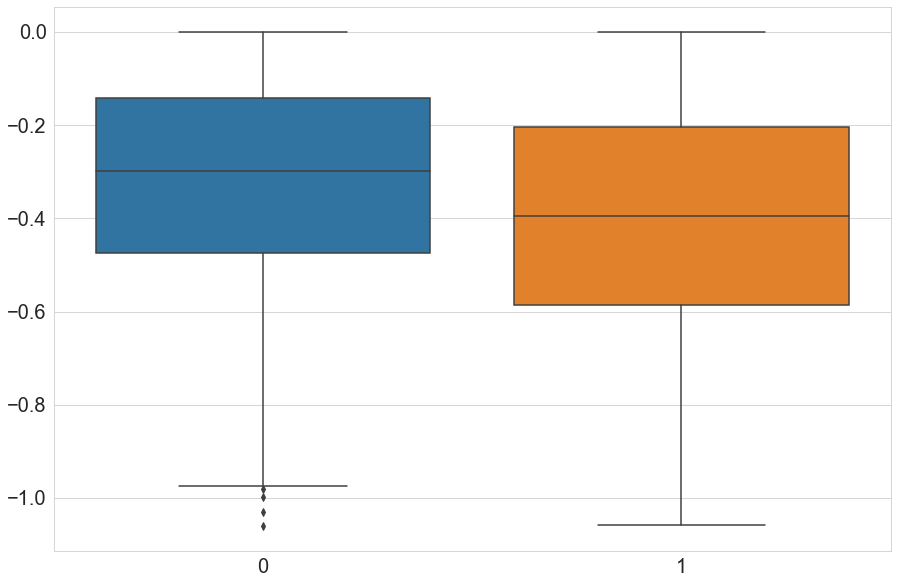

In [135]:
sns.boxplot(data=[scores_m_4, scores_m_5])

In [151]:
scores_m_3 = []
for _ in range(500): 
    sample_mats = generate_synthetic_data(20, 3)

    delta = get_delta(sample_mats[0])
    ob1_bool = True

    eta_init = np.random.uniform(0, 1, len(sample_mats))
    eta_init = eta_init / np.sum(eta_init)

    result = scipy.optimize.minimize(
        objective,
        eta_init,
        method='SLSQP',
        jac=derivative,
        bounds=[(0, 1) for _ in range(len(sample_mats))],
        constraints={'type': 'eq', 'fun': simplex_constraint},
        options={
            'maxiter': 10000,
            'disp': False
        }
    )

    score = scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta
    if score > 0: 
        ob_value = result['fun']
        scores_m_3.append(ob_value)
    else: 
        scores_m_3.append(score)
    


/var/folders/bk/cxdpc18j5fsc5wy5447dkm740000gn/T/ipykernel_12866/2515464887.py:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  ob_fn = lambda k: sum(eigs[-k:]) - k * delta


In [152]:
scores_m_2 = []
for _ in range(500): 
    sample_mats = generate_synthetic_data(20, 2)

    delta = get_delta(sample_mats[0])
    ob1_bool = True

    eta_init = np.random.uniform(0, 1, len(sample_mats))
    eta_init = eta_init / np.sum(eta_init)

    result = scipy.optimize.minimize(
        objective,
        eta_init,
        method='SLSQP',
        jac=derivative,
        bounds=[(0, 1) for _ in range(len(sample_mats))],
        constraints={'type': 'eq', 'fun': simplex_constraint},
        options={
            'maxiter': 10000,
            'disp': False
        }
    )

    score = scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta
    if score > 0: 
        ob_value = result['fun']
        scores_m_2.append(ob_value)
    else: 
        scores_m_2.append(score)

/var/folders/bk/cxdpc18j5fsc5wy5447dkm740000gn/T/ipykernel_12866/2515464887.py:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  ob_fn = lambda k: sum(eigs[-k:]) - k * delta


In [155]:
score_dict = {
    '2': scores_m_2,
    '3': scores_m_3,
    '4': scores_m_4,
    '5': scores_m_5
}

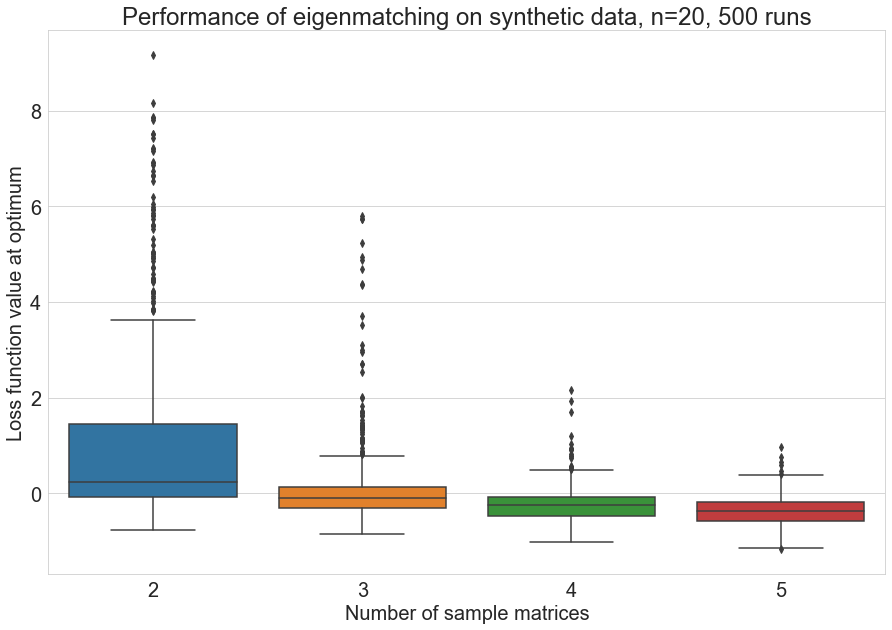

In [161]:
sns.boxplot(data=pd.DataFrame(score_dict))
plt.ylabel('Loss function value at optimum')
plt.xlabel('Number of sample matrices')
plt.title('Performance of eigenmatching on synthetic data, n=20, 500 runs')
plt.savefig('figs/synthetic_data_n_20.png')

In [146]:
scipy.stats.describe(scores_m_2)

DescribeResult(nobs=198, minmax=(-0.8575696954285901, -4.580764050210462e-05), mean=-0.22107566170714202, variance=0.03136876920637914, skewness=-0.849080172343374, kurtosis=0.2135929912380763)

In [147]:
len(scores_m_2)

198

In [148]:
len(scores_m_3)

369